# Problem Statement

We are interested in revealing the most significant cost drivers in the construction of a desalination plant.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns',160)

# Data Inspection and Cleaning

In [2]:
#load and inspect top few rows
raw_df = pd.read_excel('raw.xlsx')
raw_df.head(4)

,Country,Region,Subregion,Location,State/Region,Location type,Project name,Capacity (m3/d),Size,Capacity (MGD),Capacity (MIGD),Units,Unit size (m3/d),Unit size (MGD),Unit size (MIGD),Technical notes,Technology,Primary Reuse Sector,Thermal design,Thermal equipment,Membrane supplier (RO),Membrane type (RO),ERD supplier,ERD type,DAF pretreatment supplier,DAF brand,MF/UF Pretreatment Supplier,MF/UF brand,Other pretreatment,Feedwater,Award date,Online date,Consultant,Consultant 2,Consultant 3,Customer type,Industry,Customer,Plant status,Plant type,Plant supplier,Plant supplier share,Plant supplier 2,Plant supplier 2 share,Plant supplier 3,Plant supplier 3 share,Plant supplier 4,Plant supplier 4 share,Plant supplier 5,Plant supplier 5 share,Procurement model,Concession period,Dev consortium,Developer,Dev share,Developer 2,Dev2 share,Developer 3,Dev3 share,Developer 4,Dev4 share,Developer 5,Dev5 share,Developer 6,Dev6 share,EPC price,Water price (USD/m3),Last update,Contact,Feedwater Ph,Feedwater salinity,Feedwater temp minimum,Feedwater temp maximum,Product water salinity,Product water temp,Civil contractor (off-shore),Civil contractor (on-shore),Consultant.1,Developer/co-developer,ED/EDR system supplier,Engineering Consultancy,Environmental advisor,EPC contractor (desal),EPC contractor (pipeline),EPC contractor (power),EPCM contractor,Equipment Supplier : Desal (unspecified),Equipment supplier : Membranes (Not specified / Other),Equipment Supplier: Chemical Feed System,Equipment Supplier: Energy Recovery Device,Equipment Supplier: Glass Reinforced Polyester Pipes and Fittings,Equipment Supplier: High Pressure Pipe Materials,Equipment Supplier: Low Pressure Pipe Materials,Equipment Supplier: Membranes ( NF ),Equipment Supplier: Membranes ( UF ),Equipment Supplier: Motors,Equipment Supplier: Pipes (unspecified),Equipment Supplier: Pressure vessels,Equipment supplier: Pretreatment (DAF),Equipment Supplier: Pretreatment (Other),Equipment Supplier: Pumps: Brine circulation (concentrate disposal),Equipment Supplier: Pumps: Brine circulation (recirculation - MSF only),Equipment Supplier: Pumps: High pressure,Equipment Supplier: Pumps: Not specified/other,Equipment Supplier: Steel,Equipment Supplier: Valves,Financial advisor,Government agency,Holding Company,Insurance adviser,Legal advisor,Lender,Lender engineer,O&M contractor,Off-taker,Owners engineer,Plant owner,Prime contractor,Project Company,Subcontractor,Technical advisor,Technology provider,Winner,Short listed,Bid submitted,Pre qualified,Statement of qualification,RO System,RO Configuration,RO Feed Pump Drive,RO Control Type,RO Energy Recovery,RO Electrical Power Consumption,RO Membrane Type,RO Pre Treament 1st Stage,RO NPS Or MWCO,RO Pre Treament 2nd Stage,RO Pre Treament 3rd Stage,RO Pre Treament 4th Stage,RO Pre Treament 5th Stage,RO Passivation,RO Disinfection,RO Dosed Chemical 1st Stage,MED Design,MED System,MED Equipment,MED Type,MED Geometry,MED Configuration,MED Power Consumption,MED Gain Output Ratio,MSF Design,MSF System,MSF Equipment,MSF Type,MSF Geometry,MSF Configuration,MSF Heat Recovery Stages,MSF Heat Rejection Stages,MSF Gain Output Ratio
0,Afghanistan,Asia Pacific,Southern Asia,Afghanistan,NaN,Land based,Afghanistan,227.0,S,0.06,0.05,1.0,227.0,0.06,0.05,NaN,RO (Reverse Osmosis),NaN,NaN,NaN,NaN,Spiral Wound Membrane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brackish water or inland water (TDS 3000ppm - ...,2006.0,2007.0,NaN,NaN,NaN,Military purposes (TDS 10ppm- <1000ppm),NaN,NaN,Online,NaN,Corodex Industries,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-11 14:23:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Corodex Industries,NaN,NaN,NaN,NaN,"Toray Industries, Inc.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Concorde-Corodex Group,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spiral Wound Membrane,NaN,NaN,NaN,NaN,N

The target variable, EPC Price is our most important variable. Only records with non-missing price entries will be considered.

In [3]:
#get number of entries and columns
df = raw_df[raw_df['EPC price'].notna()]
df.shape

(10314, 160)

Let's see the percentage of missing values for each column in the dataframe.

In [4]:
missing = df.isna().sum()*100/df.shape[0]
missing.sort_values(ascending=False)

ED/EDR system supplier                                                     100.0
Equipment Supplier: Pumps: Brine circulation (recirculation - MSF only)    100.0
Equipment Supplier: Pumps: Brine circulation (concentrate disposal)        100.0
Equipment Supplier: Low Pressure Pipe Materials                            100.0
Insurance adviser                                                          100.0
                                                                           ...  
Region                                                                       0.0
EPC price                                                                    0.0
Plant status                                                                 0.0
Technology                                                                   0.0
Country                                                                      0.0
Length: 160, dtype: float64

Let's drop columns with over 90 percent missing values

In [5]:
to_drop = missing[missing>90].index
df = df.drop(to_drop,axis=1)
df.shape

(10314, 40)

This leaves us with about 25 percent of the initial columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10314 entries, 4 to 21928
Data columns (total 40 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   Country                                                 10314 non-null  object        
 1   Region                                                  10314 non-null  object        
 2   Subregion                                               10314 non-null  object        
 3   Location                                                9502 non-null   object        
 4   State/Region                                            3077 non-null   object        
 5   Location type                                           10305 non-null  object        
 6   Project name                                            10313 non-null  object        
 7   Capacity (m3/d)                                         10

- There are 3 location variables with no missing values. Dropping the **State/region** variable might not hurt our model 
- The **Unit Size** and **Capacity** variables appear to be repeated with diffent units
- Variables like **thermal design**, **industry**, and **water salinity** have too many missing values.
- **EPC price** is an object variable. 

In [7]:
df['EPC price'].sample(5)

7470     1,220,000 USD
5282       410,000 USD
12775      410,000 USD
4872     5,200,000 USD
7992       490,000 USD
Name: EPC price, dtype: object

Let's confirm that we have consistent currencies

In [8]:
df['EPC price'].str.split(expand=True)[1].unique()

array(['USD', 'QAR', 'EUR', 'JOD', 'BRL', 'INR', 'SGD', 'CNY', 'TWD',
       'MAD', 'SAR', 'OMR'], dtype=object)

We'll need to convert the prices to a base currency (USD/EUR). 

In [9]:
#extract currency
df['currency'] = df['EPC price'].str.split(expand=True)[1]

#extract price value
df['EPC price'] = df['EPC price'].str.split(expand=True)[0].str.replace(',','')

#convert EPC Price to numeric
df['EPC price'] = pd.to_numeric(df['EPC price'])

#get unique currencies
symbols = df['currency'].unique()

In [10]:
#get current exchange rate for each currency
import requests, os, json
import api_key
KEY = api_key.KEY
base = 'USD'
symbols = ','.join(symbols)
url = f"https://api.apilayer.com/fixer/latest?base={base}&symbols={symbols}&apikey={KEY}"

if 'rates.json' in os.listdir():
    with open("rates.json", "r") as f:
        rates = json.load(f)
else:
    resp = requests.get(url)
    rates = resp.json()['rates']
    with open("rates.json", "w") as f:
        json.dump(rates, f)

In [11]:
rates

{'USD': 1,
 'QAR': 3.64104,
 'EUR': 1.019905,
 'JOD': 0.709027,
 'BRL': 5.415887,
 'INR': 81.856899,
 'SGD': 1.434697,
 'CNY': 7.115982,
 'TWD': 31.881197,
 'MAD': 10.95103,
 'SAR': 3.75772,
 'OMR': 0.38505}

In [12]:
#convert prices
df['epc_price(usd)'] = df.apply(lambda x: round(x['EPC price']/rates[x['currency']],2),axis=1 )

In [13]:
#make column names and string values consistent
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')
for column in df.select_dtypes(include='O').columns:
    if column != 'country':
        df[column] = df[column].str.lower()

In [14]:
#get stats about numeric columns
df.describe()

,capacity_(m3/d),capacity_(mgd),capacity_(migd),units,unit_size_(m3/d),unit_size_(mgd),unit_size_(migd),award_date,online_date,plant_supplier_share,epc_price,product_water_salinity,epc_price(usd)
count,10311.000000,10311.000000,10311.000000,10102.000000,10099.000000,10099.000000,10099.000000,10313.000000,10308.000000,9182.000000,1.031400e+04,1105.000000,1.031400e+04
mean,5597.808554,1.478987,1.231298,1.788656,1569.845008,0.414838,0.345149,1988.509357,1989.356907,98.494768,9.923041e+06,24.561267,8.612353e+06
std,32052.868682,8.468442,7.050852,7.984676,4920.409954,1.299952,1.082488,11.244649,11.147720,8.902144,9.489007e+07,110.949940,6.414724e+07
min,8.000000,0.000000,0.000000,1.000000,14.250000,0.000000,0.000000,1944.000000,1945.000000,0.000000,8.000000e+03,0.000000,8.000000e+03
25%,240.000000,0.060000,0.050000,1.000000,200.000000,0.050000,0.040000,1981.000000,1982.000000,100.000000,2.712500e+05,0.000000,2.712500e+05
50%,550.000000,0.150000,0.120000,1.000000,480.000000,0.130000,0.110000,1990.000000,1990.000000,100.000000,7.200000e+05,0.000000,7.200000e+05
75%,1892.000000,0.500000,0.420000,2.000000,1200.000000,0.320000,0.260000,1997.000000,1998.000000,100.000000,2.320000e+06,0.000000,2.310000e+06
max,909000.000000,240.160000,199.960000,600.000000,140000.000000,36.990000,30.800000,2021.000000,2023.000000,100.000000,4.670000e+09,1500.000000,2.560000e+09


We'll need to scale the numerical variables later on since some of them have a wide range

# EDA

## EPC Price

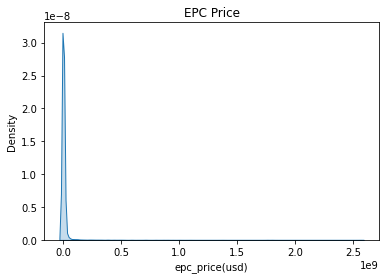

In [15]:
sns.kdeplot(df['epc_price(usd)'],shade=True)
plt.title('EPC Price');

It costs less than **half a billion dollars** to build a lot of plants in the dataset.

Machine learning models could find it difficult to learn properly from a heavily skewed target variable. Let's log transform the price variable

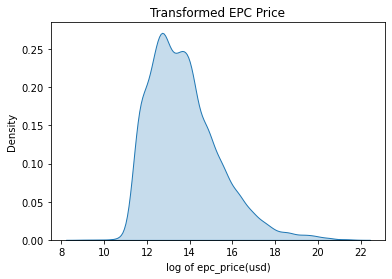

In [16]:
df['log_price'] = np.log1p(df['epc_price(usd)'])
sns.kdeplot(df['log_price'],shade=True)
plt.title('Transformed EPC Price')
plt.xlabel('log of epc_price(usd)');

## Award Date

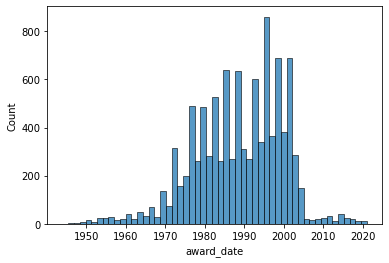

In [17]:
sns.histplot(df.award_date);

Most of the plant contracts were awarded between the late 1900s and early 2000s 

## Award Date and EPC Price

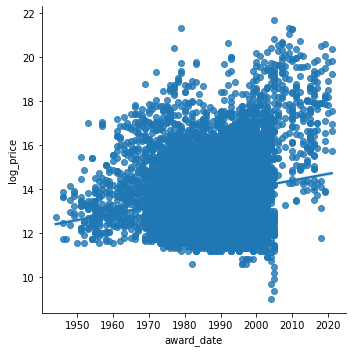

In [92]:
sns.lmplot(x='award_date',y='log_price',data=df);

Older plant contracts typically cost less than more recent plant contracts

## Country

In [19]:
df.country.nunique()

143

The dataset contains plants built in about 143 countries

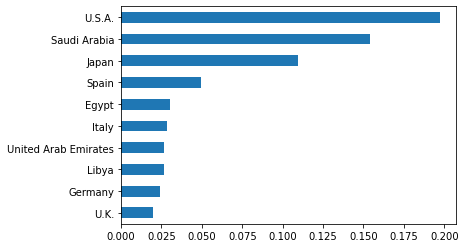

In [20]:
df.country.value_counts(normalize=True,ascending=True)[-10:].plot.barh();

Over **45 percent** of the plants were built in **America and Asia**

## EPC Price and Location

In [21]:
#find average numbber of plants per country
df.country.value_counts().median()

12.0

We'll calculate the average cost to build a plant in countries with at least 12 plants

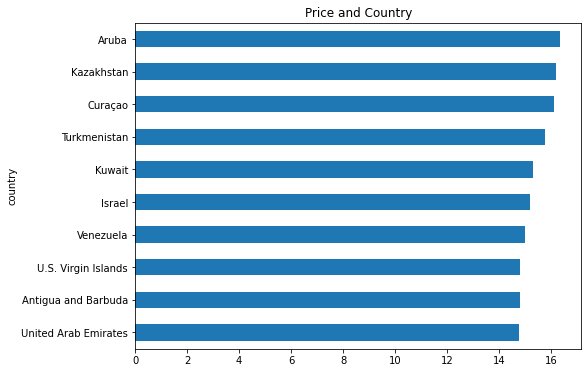

In [22]:
average_prices = df.groupby('country')['log_price'].agg(['mean','count'])

plt.figure(figsize=(8,6))
average_prices[average_prices['count']>=12]['mean'].sort_values()[-10:].plot.barh()
plt.title('Price and Country');

It is more expensive to build a plant in countries with a dry climate, though this is not a strong correlation.

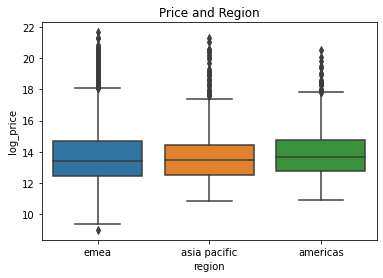

In [23]:
sns.boxplot(x='region',y='log_price',data=df)
plt.title('Price and Region');

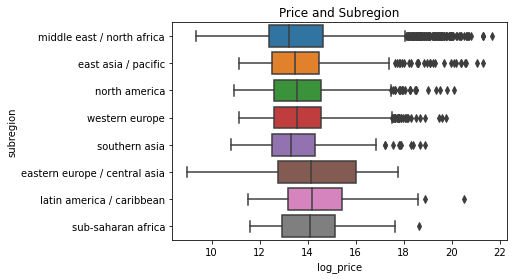

In [24]:
sns.boxplot(y='subregion',x='log_price',data=df)
plt.title('Price and Subregion');

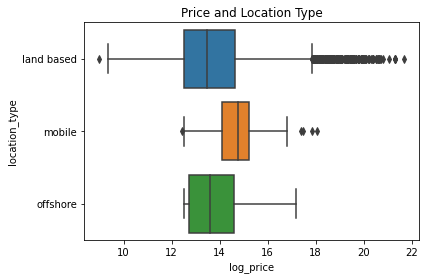

In [25]:
sns.boxplot(y='location_type',x='log_price',data=df)
plt.title('Price and Location Type');

There hasn't been a strong relationship between price and most of the location variables. We'll create another column to record the continent of each country.

In [26]:
df['country'].unique()

array(['Algeria', 'Australia', 'Bahrain', 'Canada', 'Egypt', 'France',
       'Greece', 'India', 'Iran', 'Iraq', 'Italy', 'Japan', 'Jordan',
       'Kazakhstan', 'Libya', 'Mexico', 'Morocco', 'Myanmar', 'Oman',
       'Poland', 'Qatar', 'Saudi Arabia', 'South Korea', 'Spain', 'Syria',
       'U.K.', 'U.S.A.', 'United Arab Emirates', 'Yemen', 'Antarctica',
       'Antigua and Barbuda', 'Argentina', 'Aruba', 'Austria', 'Bahamas',
       'Belgium', 'Belize', 'Chile', 'Denmark', 'Ecuador', 'Germany',
       'Israel', 'Kuwait', 'Netherlands', 'Nigeria', 'Portugal', 'Russia',
       'Saint Helena', 'Sint Maarten', 'South Africa', 'Switzerland',
       'Trinidad and Tobago', 'Turkey', 'Turkmenistan', 'Azerbaijan',
       'Barbados', 'Bermuda', 'Bonaire, Sint Eustatius and Saba',
       'Brazil', 'Cabo Verde', 'China', 'Indonesia', 'Ireland', 'Lebanon',
       'Liechtenstein', 'Malaysia', 'Pakistan', 'Philippines', 'Serbia',
       'Thailand', 'Tunisia', 'British Virgin Islands', 'Bulgaria',
 

Some of the country values are regions. We'll replace these countries with their actual countries. We'll also make the country names consistent

In [27]:
#clean country column
df['country'][(df['country'].str.contains('U.K')) | (df['country'].str.contains('UK'))] = 'United Kingdom'
df['country'][(df['country'].str.contains('U.S')) | (df['country'].str.contains('US'))] = 'United States'

In [28]:
#generate continent 
import pycountry_convert as pc

continents = {}
for country in df['country'].unique():
    try:
        country_code = pc.country_name_to_country_alpha2(country)
        continent = pc.country_alpha2_to_continent_code(country_code) 
        continents[country] = continent
    except:
        print(country)

Antarctica
Saint Helena
Sint Maarten
United States Minor Outlying Islands
Saint Barthelemy


In [29]:
#manually fill the continent values for the unidentified countries
others = {'Antarctica':'Antarctica','Saint Helena':'AF','Sint Maarten':'NA',
         'United States Minor Outlying Islands':'NA','Saint Barthelemy':'NA'}
continents.update(others)

In [30]:
#map each country to their respective continents
df['continent'] = df['country'].map(continents)

#check the resulting unique continents
df['continent'].unique()

array(['AF', 'OC', 'AS', 'NA', 'EU', 'Antarctica', 'SA'], dtype=object)

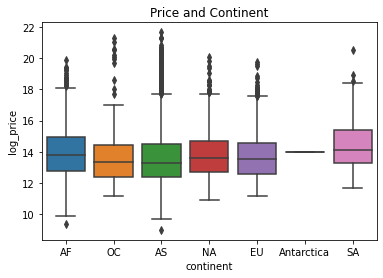

In [31]:
sns.boxplot(x='continent',y='log_price',data=df)
plt.title('Price and Continent');

Maybe location is not as important as we expect it to be

In [77]:
df.thermal_design.value_counts()

flash                                  648
mvc (mechanical vapour compression)    359
tvc (thermal vapor compression)        186
med (pure)                              15
tvc (thermal vapour compression)         1
Name: thermal_design, dtype: int64

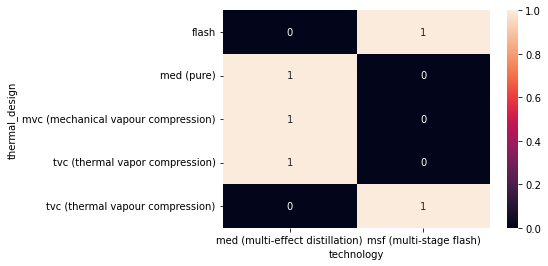

In [76]:
sns.heatmap(pd.crosstab(df.thermal_design,df.technology,normalize='index'),annot=True);

In [ ]:
sns.heatmap(pd.crosstab(,annot=True);

## EPC Price and Numerical Features

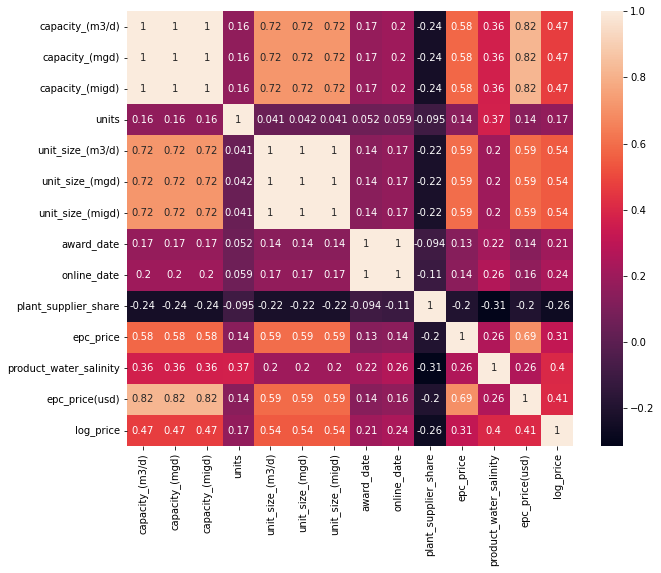

In [32]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True);

- The size and capacity of a plant greatly affect its price
- The supplier's share on plant's contract affects its price negatively
- online date and award date are highy correlated

## EPC Price and Size

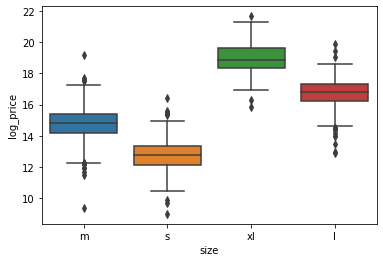

In [33]:
sns.boxplot(x='size',y='log_price',data=df);

Large plants clearly cost more

## EPC Price and Technology

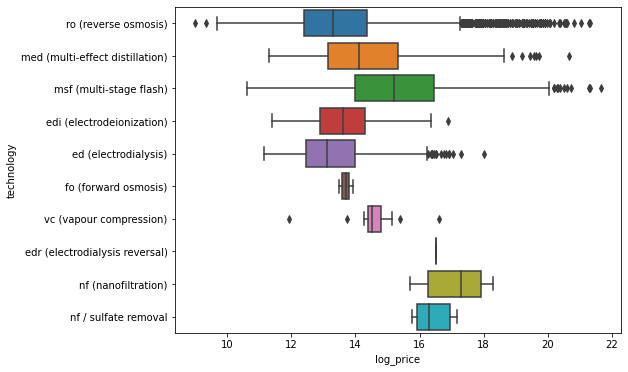

In [34]:
plt.figure(figsize=(8,6))
sns.boxplot(y='technology',x='log_price',data=df);

On average, it is more expensive to use nanofiltration on a plant

## EPC Price and Plant Status

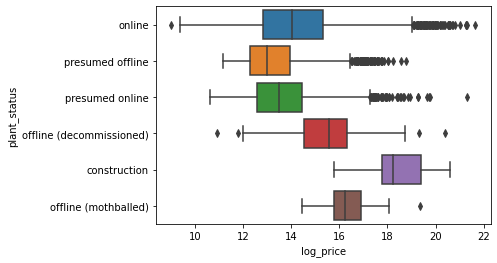

In [35]:
sns.boxplot(y='plant_status',x='log_price',data=df);

Plants under construction tend to cost more. This variable might not be so helpful in predicting a plant's cost since a plant's status can only be known when the construction or operation must have begun

## EPC Price and Plant Type

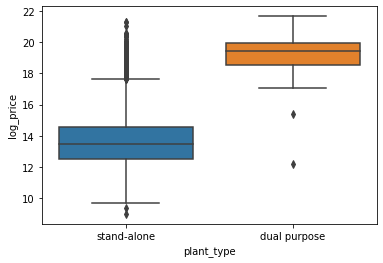

In [36]:
sns.boxplot(x='plant_type',y='log_price',data=df);

Dual purpose plants cost more

## EPC Price and Procurement Model

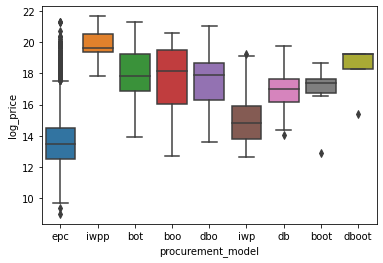

In [37]:
sns.boxplot(x='procurement_model',y='log_price',data=df);

**iwpp** models appear to cost more

## EPC Price and RO System

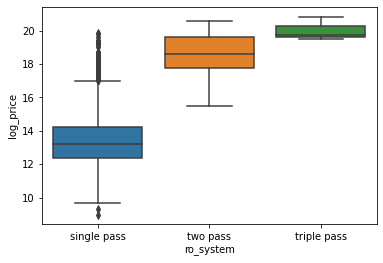

In [38]:
sns.boxplot(x='ro_system',y='log_price',data=df);

EPC Price and **ro_system** are correlated

## EPC Price and RO Feed Pump Drive

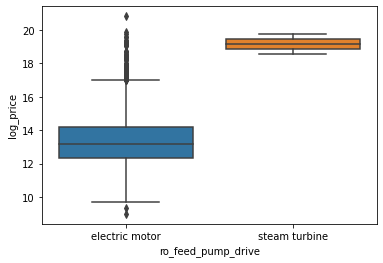

In [39]:
sns.boxplot(x='ro_feed_pump_drive',y='log_price',data=df);

Steam turbine plants are more expensive

## EPC Price and RO Membrane Type

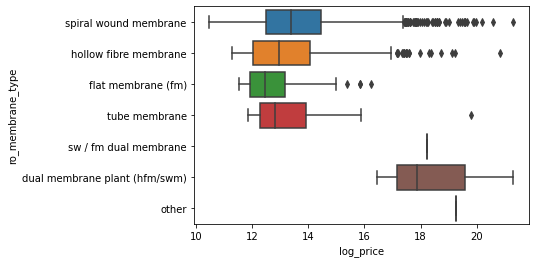

In [40]:
sns.boxplot(y='ro_membrane_type',x='log_price',data=df);

The price of a desalination plant and the type of membrane seem to be related in a measurable way.

Overall, a plant's technical specifications can reveal a lot about its price.

# Data Preprocessing

We'll exclude the following variables in building our model:
- **project_name** : We do not expect name to affect the price of a plant
- **(mgd)**, **(migd)** variables: since these are just unit conversions of the capacity and size variables
- **award_date, online_date, plant_status** : These are not variables we would know beforehand
- **epc_price, currency, epc_price(usd),**: We only need the **log_price** as our target variable

In [41]:
#seperate features from target
X = df[['country', 'region', 'subregion', 'location', 'state/region',
       'location_type', 'capacity_(m3/d)', 'size',
       'units', 'unit_size_(m3/d)',
       'technology', 'thermal_design',
       'membrane_type_(ro)', 'feedwater',
       'customer_type', 'industry', 'customer', 'plant_type',
       'plant_supplier', 'plant_supplier_share', 'procurement_model',
       'product_water_salinity',
       'epc_contractor_(desal)',
       'equipment_supplier_:_membranes_(not_specified_/_other)',
       'holding_company', 'plant_owner', 'bid_submitted', 'ro_system',
       'ro_feed_pump_drive', 'ro_membrane_type',
       'continent']]
y = df['log_price']

In [42]:
#split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=0)

In [43]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((6600, 31), (2063, 31), (1651, 31), (6600,), (2063,), (1651,))

## Handle Missing Values

In [44]:
#seperate numerical columns from categorical ones
num_train = X_train.select_dtypes(exclude='O')
cat_train = X_train.select_dtypes(include='O')

In [45]:
#fill numerical columns with mean and categorical columns with most frequent
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

#fill missing values
num_train = pd.DataFrame(num_imputer.fit_transform(num_train),columns = num_train.columns)
cat_train = pd.DataFrame(cat_imputer.fit_transform(cat_train),columns = cat_train.columns)

## Feature Scaling

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#scale numerical data
num_scaled = scaler.fit_transform(num_train)
num_scaled_df = pd.DataFrame(num_scaled,columns=num_train.columns)

## Categorical Encoding

In [47]:
#explore cat columns
for column in cat_train.columns:
    print(f'{column}: {cat_train[column].nunique()}')

country: 131
region: 3
subregion: 8
location: 2050
state/region: 182
location_type: 3
size: 4
technology: 10
thermal_design: 4
membrane_type_(ro): 5
feedwater: 6
customer_type: 7
industry: 10
customer: 1420
plant_type: 2
plant_supplier: 473
procurement_model: 9
epc_contractor_(desal): 457
equipment_supplier_:_membranes_(not_specified_/_other): 50
holding_company: 279
plant_owner: 1420
bid_submitted: 415
ro_system: 3
ro_feed_pump_drive: 2
ro_membrane_type: 5
continent: 7


We'll consider columns with not more than 10 categories

In [48]:
not_more_than_10 = [column for column in cat_train.columns if cat_train[column].nunique() <= 10]
cat_train_10 = cat_train[not_more_than_10]

In [49]:
cat_train_10.head()

,region,subregion,location_type,size,technology,thermal_design,membrane_type_(ro),feedwater,customer_type,industry,plant_type,procurement_model,ro_system,ro_feed_pump_drive,ro_membrane_type,continent
0,emea,middle east / north africa,land based,m,med (multi-effect distillation),tvc (thermal vapor compression),spiral wound membrane,seawater (tds 20000ppm - 50000ppm),industry (tds <10ppm),refining/chemicals,stand-alone,epc,single pass,electric motor,spiral wound membrane,AS
1,asia pacific,east asia / pacific,land based,s,ro (reverse osmosis),flash,spiral wound membrane,wastewater,industry (tds <10ppm),electronics,stand-alone,epc,single pass,electric motor,spiral wound membrane,AS
2,emea,western europe,land based,s,ro (reverse osmosis),flash,spiral wound membrane,brackish water or inland water (tds 3000ppm - ...,tourist facilities as drinking water (tds 10pp...,power,stand-alone,epc,single pass,electric motor,spiral wound membrane,EU
3,emea,middle east / north africa,land based,s,ro (reverse osmosis),flash,spiral wound membrane,brackish water or inland water (tds 3000ppm - ...,tourist facilities as drinking water (tds 10pp...,power,stand-alone,epc,single pass,electric motor,spiral wound membrane,AS
4,americas,latin america / caribbean,land based,s,ro (reverse osmosis),flash,spiral wound membrane,seawater (tds 20000ppm - 50000ppm),industry (tds <10ppm),power,stand-alone,epc,single pass,electric motor,spiral wound membrane,SA


In [50]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first',handle_unknown='ignore',sparse=False)

#encode categorical data
cat_encoded = encoder.fit_transform(cat_train_10)
cat_encoded_df = pd.DataFrame(cat_encoded,columns=encoder.get_feature_names_out())

In [51]:
#concatenate numerical and categorical data
X_train_preprocessed = pd.concat([num_scaled_df,cat_encoded_df],axis=1)
X_train_preprocessed.columns = X_train_preprocessed.columns.str.replace(' ','_').str.replace(',','_').str.replace('[','_').str.replace(']','_').str.replace('<','_') 
X_train_preprocessed.head()

,capacity_(m3/d),units,unit_size_(m3/d),plant_supplier_share,product_water_salinity,region_asia_pacific,region_emea,subregion_eastern_europe_/_central_asia,subregion_latin_america_/_caribbean,subregion_middle_east_/_north_africa,subregion_north_america,subregion_southern_asia,subregion_sub-saharan_africa,subregion_western_europe,location_type_mobile,location_type_offshore,size_m,size_s,size_xl,technology_edi_(electrodeionization),technology_edr_(electrodialysis_reversal),technology_fo_(forward_osmosis),technology_med_(multi-effect_distillation),technology_msf_(multi-stage_flash),technology_nf_(nanofiltration),technology_nf_/_sulfate_removal,technology_ro_(reverse_osmosis),technology_vc_(vapour_compression),thermal_design_med_(pure),thermal_design_mvc_(mechanical_vapour_compression),thermal_design_tvc_(thermal_vapor_compression),membrane_type_(ro)_flat_membrane_(fm),membrane_type_(ro)_hollow_fibre_membrane,membrane_type_(ro)_spiral_wound_membrane,membrane_type_(ro)_tube_membrane,feedwater_brine_or_concentrated_seawater_(tds_>50000ppm),feedwater_pure_water_or_tap_water_(tds__500ppm),feedwater_river_water_or_low_concentrated_saline_water_(tds_500ppm_-__3000ppm),feedwater_seawater_(tds_20000ppm_-_50000ppm),feedwater_wastewater,customer_type_discharge,customer_type_industry_(tds__10ppm),customer_type_irrigation_(tds__1000ppm),customer_type_military_purposes_(tds_10ppm-__1000ppm),customer_type_municipalities_as_drinking_water_(tds_10ppm_-__1000ppm),customer_type_tourist_facilities_as_drinking_water_(tds_10ppm_-__1000ppm),industry_food_&_beverage,industry_general,industry_metals,industry_mining,industry_oil_&_gas,industry_power,industry_pulp_&_paper,industry_refining/chemicals,industry_textiles,plant_type_stand-alone,procurement_model_boot,procurement_model_bot,procurement_model_db,procurement_model_dbo,procurement_model_dboot,procurement_model_epc,procurement_model_iwp,procurement_model_iwpp,ro_system_triple_pass,ro_system_two_pass,ro_feed_pump_drive_steam_turbine,ro_membrane_type_flat_membrane_(fm),ro_membrane_type_hollow_fibre_membrane,ro_membrane_type_spiral_wound_membrane,ro_membrane_type_tube_membrane,continent_AS,continent_Antarctica,continent_EU,continent_NA,continent_OC,continent_SA
0,0.044338,0.115968,0.172608,0.159603,-0.06586,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.164387,-0.088518,-0.254166,0.159603,-0.06586,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.165594,-0.088518,-0.262218,0.159603,-0.06586,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.165986,-0.088518,-0.264835,0.159603,-0.06586,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.169816,-0.088518,-0.290401,0.159603,-0.06586,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [52]:
def preprocess_1(df,num_imputer,cat_imputer,scaler,encoder):
    #seperate numerical columns from categorical ones
    num_df = df.select_dtypes(exclude='O')
    cat_df = df.select_dtypes(include='O')
    
    #fill missing values
    num_df = pd.DataFrame(num_imputer.transform(num_df),columns = num_df.columns)
    cat_df = pd.DataFrame(cat_imputer.transform(cat_df),columns = cat_df.columns)[not_more_than_10]
    
    #scale numerical data
    num_scaled = scaler.transform(num_df)
    num_scaled_df = pd.DataFrame(num_scaled,columns=num_df.columns)
    
    #encode categorical data
    cat_encoded = encoder.transform(cat_df)
    cat_encoded_df = pd.DataFrame(cat_encoded,columns=encoder.get_feature_names_out())
    
    #concatenate numerical and categorical data
    df_preprocessed = pd.concat([num_scaled_df,cat_encoded_df],axis=1)
    df_preprocessed.columns = df_preprocessed.columns.str.replace(' ','_').str.replace(',','_').str.replace('[','_').str.replace(']','_').str.replace('<','_') 
    return df_preprocessed

In [53]:
#preprocess val and test sets
X_val_preprocessed = preprocess_1(X_val,num_imputer,cat_imputer,scaler,encoder)
X_test_preprocessed = preprocess_1(X_test,num_imputer,cat_imputer,scaler,encoder)

# Baseline Model

We need to establish a baseline score for our model(s) to beat. If we were not using machine learning, we'd probably do some sort of aggregation over the data we have. For example, we might choose to aggregate over the size of plant.

In [54]:
#aggregate over train data
agg_prices = df.loc[X_train.index].groupby('size')['epc_price(usd)'].mean().to_dict()

In [55]:
from sklearn.metrics import mean_absolute_error as mae
preds = X_val['size'].map(agg_prices)
mae(y_val,preds)

8930263.259175224

We have to build a model that beats this score (lesser is better)

# Model Building

In [56]:
# import some models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# import the evaluation function
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

In [57]:
# create a list of models
models = [LinearRegression(),
          Lasso(),
          DecisionTreeRegressor(random_state=42),
          RandomForestRegressor(random_state=42),
          ExtraTreesRegressor(random_state=42),
          GradientBoostingRegressor(random_state=42),
          AdaBoostRegressor(random_state=42),
          XGBRegressor(random_state=42),
          LGBMRegressor(random_state=42),
          CatBoostRegressor(random_state=42,verbose=0)
         ]

In [58]:
for model in models:
    model.fit(X_train_preprocessed,y_train)
    val_predictions = model.predict(X_val_preprocessed)
    print(f'{model.__class__.__name__}: {mae(y_val,val_predictions)}') 

LinearRegression: 0.5578014603652204
Lasso: 1.27207409712698
DecisionTreeRegressor: 0.1726732397309619
RandomForestRegressor: 0.14911092738793724
ExtraTreesRegressor: 0.15442097179842035
GradientBoostingRegressor: 0.15770687907412476
AdaBoostRegressor: 0.42129873731857703
XGBRegressor: 0.15830907110482062
LGBMRegressor: 0.14829112920306595
CatBoostRegressor: 0.15348416188426542


**LGBMRegressor** appears to perform best but this is only a speculation as we have only tested the models on one fold. We can also see that the tree-based and boosting algorithms give similar results.

Assuming **LGBMRegressor** is our best performing model, let's see how its performance compares to the baseline score

In [59]:
#evaluate mae on validation set
val_preds = np.expm1(models[-2].predict(X_val_preprocessed))
y_true = np.expm1(y_val)
mae(y_true,val_preds)

4646174.382637453

This machine learning model reduces the error rate of the baseline predictions by almost **50 percent**.

We can pass all the categorical variables into **CatBoostRegressor**. The algorithm handles the encoding steps

In [60]:
def preprocess_2(df,num_imputer,cat_imputer,scaler):
    #seperate numerical columns from categorical ones
    num_df = df.select_dtypes(exclude='O')
    cat_df = df.select_dtypes(include='O')
    
    #fill missing values
    num_df = pd.DataFrame(num_imputer.transform(num_df),columns = num_df.columns)
    cat_df = pd.DataFrame(cat_imputer.transform(cat_df),columns = cat_df.columns)
    
    #scale numerical data
    num_scaled = scaler.transform(num_df)
    num_scaled_df = pd.DataFrame(num_scaled,columns=num_df.columns)
    
    #concatenate scaled numerical features and imputed categorical features
    return pd.concat([num_scaled_df,cat_df],axis=1)

In [61]:
X_train_preprocessed = preprocess_2(X_train,num_imputer,cat_imputer,scaler)
X_val_preprocessed = preprocess_2(X_val,num_imputer,cat_imputer,scaler)
X_test_preprocessed = preprocess_2(X_test,num_imputer,cat_imputer,scaler)

In [62]:
X_train_preprocessed.head()

,capacity_(m3/d),units,unit_size_(m3/d),plant_supplier_share,product_water_salinity,country,region,subregion,location,state/region,location_type,size,technology,thermal_design,membrane_type_(ro),feedwater,customer_type,industry,customer,plant_type,plant_supplier,procurement_model,epc_contractor_(desal),equipment_supplier_:_membranes_(not_specified_/_other),holding_company,plant_owner,bid_submitted,ro_system,ro_feed_pump_drive,ro_membrane_type,continent
0,0.044338,0.115968,0.172608,0.159603,-0.06586,Oman,emea,middle east / north africa,qalhat,california,land based,m,med (multi-effect distillation),tvc (thermal vapor compression),spiral wound membrane,seawater (tds 20000ppm - 50000ppm),industry (tds <10ppm),refining/chemicals,omifci,stand-alone,entropie s.a.s.,epc,entropie s.a.s.,dupont (now dupont water solutions),veolia,omifci,veolia,single pass,electric motor,spiral wound membrane,AS
1,-0.164387,-0.088518,-0.254166,0.159603,-0.06586,Japan,asia pacific,east asia / pacific,hyogo,california,land based,s,ro (reverse osmosis),flash,spiral wound membrane,wastewater,industry (tds <10ppm),electronics,sanyo,stand-alone,unitika ltd.,epc,unitika ltd.,dupont (now dupont water solutions),unitika ltd.,sanyo,"ionics, inc.",single pass,electric motor,spiral wound membrane,AS
2,-0.165594,-0.088518,-0.262218,0.159603,-0.06586,Malta,emea,western europe,malta,california,land based,s,ro (reverse osmosis),flash,spiral wound membrane,brackish water or inland water (tds 3000ppm - ...,tourist facilities as drinking water (tds 10pp...,power,private,stand-alone,bkg water solutions,epc,bkg water solutions,dow filmtec (now dupont water solutions),bkg water solutions,private,"ionics, inc.",single pass,electric motor,spiral wound membrane,EU
3,-0.165986,-0.088518,-0.264835,0.159603,-0.06586,Saudi Arabia,emea,middle east / north africa,dhahran,california,land based,s,ro (reverse osmosis),flash,spiral wound membrane,brackish water or inland water (tds 3000ppm - ...,tourist facilities as drinking water (tds 10pp...,power,marriott,stand-alone,culligan international company,epc,culligan international company,dupont (now dupont water solutions),culligan international company,marriott,watera hellas,single pass,electric motor,spiral wound membrane,AS
4,-0.169816,-0.088518,-0.290401,0.159603,-0.06586,Peru,americas,latin america / caribbean,peru,california,land based,s,ro (reverse osmosis),flash,spiral wound membrane,seawater (tds 20000ppm - 50000ppm),industry (tds <10ppm),power,private,stand-alone,osmotec engineering gmbh (now triton water),epc,osmotec engineering gmbh (now triton water),dupont (now dupont water solutions),triton water ag,private,"ionics, inc.",single pass,electric motor,spiral wound membrane,SA


In [63]:
cat_indices = list(range(5,31))
model = CatBoostRegressor(iterations=3000,random_seed=42,logging_level='Silent',
                          loss_function='MAE',use_best_model=True)
model.fit(X=X_train_preprocessed, y=y_train, cat_features=cat_indices,
         eval_set=(X_val_preprocessed,y_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

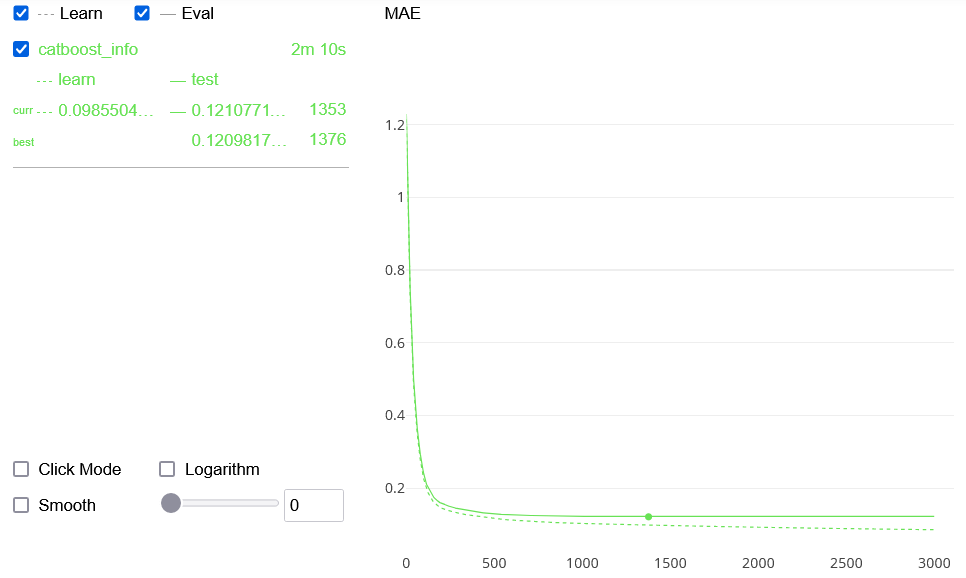

In [64]:
#display training plot
from IPython.display import Image
Image('training_plot.png')

The model's performance stopped improving after 1376 iterations. Compared to when we trained with some categorical features, the performance is better. What variables and how much did they influence the model's performance?

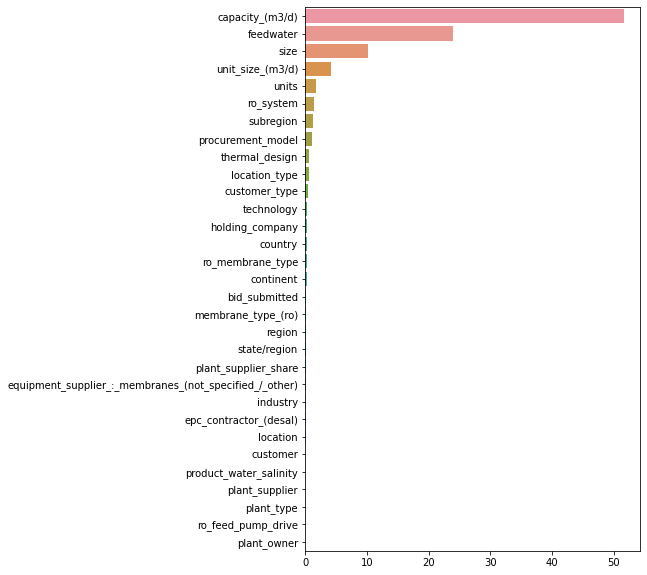

In [65]:
plt.figure(figsize=(6,10))
importances = sorted(list(zip(model.feature_importances_,model.feature_names_)),reverse=True)
x_axis = [x[0] for x in importances]
y_axis = [x[1] for x in importances]
sns.barplot(x=x_axis,y=y_axis);

Most of the important features were the same variables we considered earlier. However, **feedwater** appears to have a strong influence on price

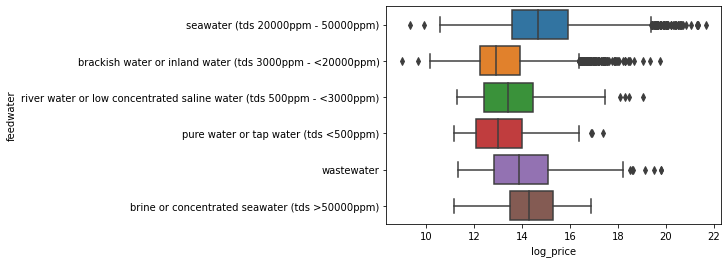

In [66]:
sns.boxplot(y='feedwater',x='log_price',data=df);

What kind of errors does this model make?

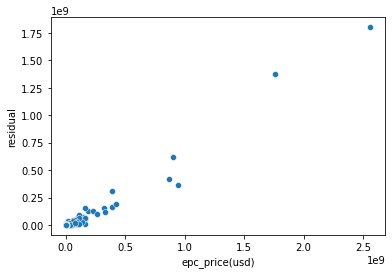

In [67]:
val_preds = np.expm1(model.predict(X_val_preprocessed))
residuals = abs(val_preds - y_true)
sns.scatterplot(y_true,residuals)
plt.xlabel('epc_price(usd)')
plt.ylabel('residual');

The good thing about this model is that the errors have a **positive linear relationship** with the true prices. This implies that the model makes small errors for small plant prices and large errors for large prices

In [68]:
(y_true < 0.25e9).sum()/len(y_true)

0.9933373712901272

Prices below a quarter billion dollars make up over 99 percent of the validation data

In [69]:
mae(y_true[y_true < 0.25e9],val_preds[y_true < 0.25e9])

1450265.7913599373

Let's test the model's performance on the unseen test set

In [70]:
test_predictions = model.predict(X_test_preprocessed)
mae(y_test,test_predictions)

0.1208312661222184

Performance on the test set mirrors that on the validation set. So, we anticipate that this model will generalize well over unseen data

In [82]:
df.columns

Index(['country', 'region', 'subregion', 'location', 'state/region',
       'location_type', 'project_name', 'capacity_(m3/d)', 'size',
       'capacity_(mgd)', 'capacity_(migd)', 'units', 'unit_size_(m3/d)',
       'unit_size_(mgd)', 'unit_size_(migd)', 'technology', 'thermal_design',
       'membrane_type_(ro)', 'feedwater', 'award_date', 'online_date',
       'customer_type', 'industry', 'customer', 'plant_status', 'plant_type',
       'plant_supplier', 'plant_supplier_share', 'procurement_model',
       'epc_price', 'last_update', 'product_water_salinity',
       'epc_contractor_(desal)',
       'equipment_supplier_:_membranes_(not_specified_/_other)',
       'holding_company', 'plant_owner', 'bid_submitted', 'ro_system',
       'ro_feed_pump_drive', 'ro_membrane_type', 'currency', 'epc_price(usd)',
       'log_price', 'continent'],
      dtype='object')

In [88]:
df[df['epc_price(usd)']<0.25e9]['size'].value_counts()

s     6410
m     3148
l      544
xl     132
Name: size, dtype: int64

In [90]:
df[df['epc_price(usd)']>0.25e9]['size'].value_counts(normalize=True)

xl    0.972973
l     0.027027
Name: size, dtype: float64

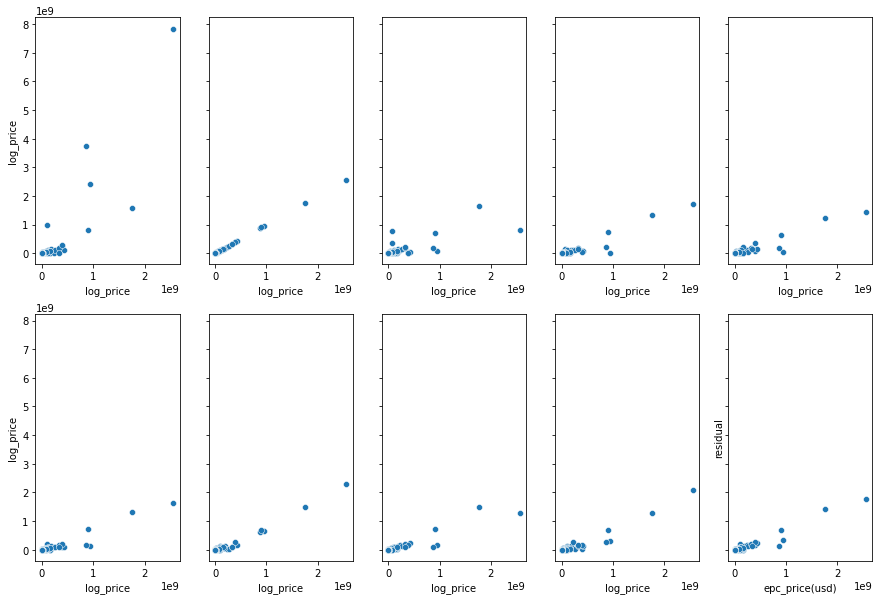

In [103]:
X_val_preprocessed = preprocess_1(X_val,num_imputer,cat_imputer,scaler,encoder)
# to create a dashboard for the boxplots
f,axes=plt.subplots(2,5, sharey=True, figsize=(15,10))

# to plot the boxplots on the dashboard
for i in range(len(models)):
    row = i//5
    col = i%5
    val_preds = np.expm1(models[i].predict(X_val_preprocessed))
    residuals = abs(val_preds - y_true)
    sns.scatterplot(y_true,residuals,ax = axes[row,col])
    plt.xlabel('epc_price(usd)')
    plt.ylabel('residual');

In [109]:
df.columns

Index(['country', 'region', 'subregion', 'location', 'state/region',
       'location_type', 'project_name', 'capacity_(m3/d)', 'size',
       'capacity_(mgd)', 'capacity_(migd)', 'units', 'unit_size_(m3/d)',
       'unit_size_(mgd)', 'unit_size_(migd)', 'technology', 'thermal_design',
       'membrane_type_(ro)', 'feedwater', 'award_date', 'online_date',
       'customer_type', 'industry', 'customer', 'plant_status', 'plant_type',
       'plant_supplier', 'plant_supplier_share', 'procurement_model',
       'epc_price', 'last_update', 'product_water_salinity',
       'epc_contractor_(desal)',
       'equipment_supplier_:_membranes_(not_specified_/_other)',
       'holding_company', 'plant_owner', 'bid_submitted', 'ro_system',
       'ro_feed_pump_drive', 'ro_membrane_type', 'currency', 'epc_price(usd)',
       'log_price', 'continent'],
      dtype='object')

In [115]:
df['membrane_type_(ro)'].value_counts()

spiral wound membrane            4155
hollow fibre membrane            1237
flat membrane (fm)                 93
tube membrane                      36
dual membrane plant (hfm/swm)       3
sw / fm dual membrane               1
other                               1
Name: membrane_type_(ro), dtype: int64

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10314 entries, 4 to 21928
Data columns (total 44 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   country                                                 10314 non-null  object        
 1   region                                                  10314 non-null  object        
 2   subregion                                               10314 non-null  object        
 3   location                                                9502 non-null   object        
 4   state/region                                            3077 non-null   object        
 5   location_type                                           10305 non-null  object        
 6   project_name                                            10313 non-null  object        
 7   capacity_(m3/d)                                         10

In [ ]:
##TO DO
# drop correlated columns
# 10 most occuring
# another level for missing values
# effect of inflation on prices
# feature_engineering
# feature_selection
# stacking
# protototyping